# Augmentation process

We will:
* Break training files into 6s long chunks with a rolling 1s window
* Extract one chunk per training file
* Perform augmentations on each training file
* Save files and csv of labels

This process assumes the following:
* One directory, `top_dir`, which contains many directories
* Each directory in `top_dir` is the label of a species
* Each species directory contains a directory called `.mp3s/`
* Each `.mp3s/` directory contains `.mp3` files.

### Options

In [1]:
top_dir = '/Volumes/seagate4/xeno-canto/aba_code_1-2/'
spect_save_path = 'results/'
csv_save_file = 'results/results.csv'

# Number of labels to use
label_subset_size = 5 #None

# Number of files to get from each label
file_subset_size = 2 #None

## Imports

In [2]:
# To automatically reload modules
%load_ext autoreload

In [3]:
# Setup to import from other dirs
import sys
import os
REPO_PATH = os.path.abspath('../../..')
sys.path.append(REPO_PATH)

# Augmentation modules
import create_training_data.code.audio_aug as aa
import create_training_data.code.spectrogram_aug as sa

## Set up files


#### Make `label_dict`

Get a dictionary associating labels with the paths to their `mp3s/` directories

In [4]:
import random
random.seed(1)

# Get list of labels in directory. Subset if desired.
labels = [label for label in os.listdir(top_dir) 
          if os.path.isdir(os.path.join(top_dir, label))]
if label_subset_size: labels = random.sample(labels, k = label_subset_size)

# Populate dictionary with pahts
label_dict = {}
for label in labels:
    label_dict[label] = os.path.join(top_dir, label, 'mp3s')

label_dict

{'calidris-bairdii': '/Volumes/seagate4/xeno-canto/aba_code_1-2/calidris-bairdii/mp3s',
 'selasphorus-platycercus': '/Volumes/seagate4/xeno-canto/aba_code_1-2/selasphorus-platycercus/mp3s',
 'aphelocoma-insularis': '/Volumes/seagate4/xeno-canto/aba_code_1-2/aphelocoma-insularis/mp3s',
 'empidonax-virescens': '/Volumes/seagate4/xeno-canto/aba_code_1-2/empidonax-virescens/mp3s',
 'buteo-jamaicensis': '/Volumes/seagate4/xeno-canto/aba_code_1-2/buteo-jamaicensis/mp3s'}

#### Get files in label_dict

In [5]:
def get_files(path, ext, file_subset_size):
    '''
    Get files matching extension within a path
    
    Return a random sample of all files within a 
    directory matching a given extension or tuple of extensions
    If a random sample is desired, provide number as an int. 
    Extension pattern matching is case-insensitive.
    
    Args:
        path (str): path to get files from
        ext (str or tuple of strs): 
            extensions of files to choose
        number (int or 'all'): number of files
            to return from this path
    
    Returns:
        list of absolute paths to matching files within 
        path. List is randomly sampled if `number` is 
        an int; otherwise, returns all files.
    '''
    
    # Make case-insensitive
    if isinstance(ext, tuple):
        ext = tuple(e.lower() for e in ext)
    
    # All files within directory
    matching_files = [os.path.join(path, file) \
                for file in os.listdir(path) \
                if file.lower().endswith(ext)]
    
    # Subsample if desired and return files
    if file_subset_size:
        return random.sample(matching_files, k = file_subset_size)
    else:
        return matching_files

Get 2 files for each label in `label_dict`. Create list of tuples, where each element is a tuple of `('path-to-audio-file', 'label-of-audio-file')`

In [6]:
file_label_tuples = []
for label in label_dict.keys():
    mp3_path = os.path.join(label_dict[label])
    matching_files = get_files(
        mp3_path,
        ext = ('.mp3', '.wav'),
        file_subset_size = file_subset_size) 

    file_label_tuples.extend((file, label) for file in matching_files)

file_label_tuples

[('/Volumes/seagate4/xeno-canto/aba_code_1-2/calidris-bairdii/mp3s/491634.mp3',
  'calidris-bairdii'),
 ('/Volumes/seagate4/xeno-canto/aba_code_1-2/calidris-bairdii/mp3s/491598.mp3',
  'calidris-bairdii'),
 ('/Volumes/seagate4/xeno-canto/aba_code_1-2/selasphorus-platycercus/mp3s/13523.mp3',
  'selasphorus-platycercus'),
 ('/Volumes/seagate4/xeno-canto/aba_code_1-2/selasphorus-platycercus/mp3s/325347.mp3',
  'selasphorus-platycercus'),
 ('/Volumes/seagate4/xeno-canto/aba_code_1-2/aphelocoma-insularis/mp3s/390116.mp3',
  'aphelocoma-insularis'),
 ('/Volumes/seagate4/xeno-canto/aba_code_1-2/aphelocoma-insularis/mp3s/359504.mp3',
  'aphelocoma-insularis'),
 ('/Volumes/seagate4/xeno-canto/aba_code_1-2/empidonax-virescens/mp3s/130133.mp3',
  'empidonax-virescens'),
 ('/Volumes/seagate4/xeno-canto/aba_code_1-2/empidonax-virescens/mp3s/370169.mp3',
  'empidonax-virescens'),
 ('/Volumes/seagate4/xeno-canto/aba_code_1-2/buteo-jamaicensis/mp3s/105950.mp3',
  'buteo-jamaicensis'),
 ('/Volumes/seag

In [7]:
import time
audios = []
for tup in file_label_tuples:
    print(f'Opening {tup[0]}')
    t0 = time.time()
    audio = aa.Audio(path = tup[0], label = tup[1])
    t1 = time.time()
    print(f'Opened. Time elapsed: {t1 - t0}')
    print(f'        File size: {len(audio.samples)/audio.sample_rate} seconds')
    audios.append(audio)
print('Finished.')

Opening /Volumes/seagate4/xeno-canto/aba_code_1-2/calidris-bairdii/mp3s/491634.mp3
Opened. Time elapsed: 0.8070540428161621
        File size: 7.368027210884354 seconds
Opening /Volumes/seagate4/xeno-canto/aba_code_1-2/calidris-bairdii/mp3s/491598.mp3
Opened. Time elapsed: 1.2813549041748047
        File size: 32.35201814058957 seconds
Opening /Volumes/seagate4/xeno-canto/aba_code_1-2/selasphorus-platycercus/mp3s/13523.mp3
Opened. Time elapsed: 0.9565792083740234
        File size: 22.589659863945577 seconds
Opening /Volumes/seagate4/xeno-canto/aba_code_1-2/selasphorus-platycercus/mp3s/325347.mp3
Opened. Time elapsed: 2.0514090061187744
        File size: 48.753786848072565 seconds
Opening /Volumes/seagate4/xeno-canto/aba_code_1-2/aphelocoma-insularis/mp3s/390116.mp3
Opened. Time elapsed: 2.1724560260772705
        File size: 52.93877551020408 seconds
Opening /Volumes/seagate4/xeno-canto/aba_code_1-2/aphelocoma-insularis/mp3s/359504.mp3
Opened. Time elapsed: 0.21900105476379395
       

## Audio manipulation

### Apply Audio manipulation functions

In [8]:
for idx, audio in enumerate(audios):
    audios[idx] = (audio
        .apply(func = aa.get_chunk)
        .apply(func = aa.cyclic_shift)
        .apply(func = aa.time_stretch_divisions)
        .apply(func = aa.pitch_shift_divisions)
        .apply(func = aa.random_filter)
    )

Create a summed and an unsummed version

In [9]:
from copy import deepcopy
audios_unsummed = audios
audios_summed = deepcopy(audios)
for idx, audio in enumerate(audios_summed):
    audios_summed[idx] = audio.apply(
        func = aa.sum_chunks,
        label_dict = label_dict,
        seed = 1
    )

## Spectrogram manipulation

### Turn the audios into spectrograms

In [10]:
spect_lists = []
audio_lists = [audios_unsummed, audios_summed]
for audio_list in audio_lists:
    spects = []
    for audio in audio_list:
        spects.append(sa.Spectrogram(
            audio = audio
        ))
    spect_lists.append(spects)

### Apply Spectrogram manipulations

In [11]:
for spects in spect_lists:
    for idx, spect in enumerate(spects):
        spects[idx] = (spect
            .apply(func = sa.make_linear_spectrogram)
            .apply(func = sa.remove_random_hi_lo_bands)
            .apply(func = sa.resize_random_bands, rows_or_cols = 'rows')
            .apply(func = sa.resize_random_bands, rows_or_cols = 'cols')
            .apply(func = sa.resize_spect_random_interpolation, width=299, height=299)
            .apply(
                func = sa.color_jitter,
                hue = None
            )
        )

## Plot results

Below we define a small utility that plots all of the spectrograms using the `Spectrogram` method `plot_axes`.

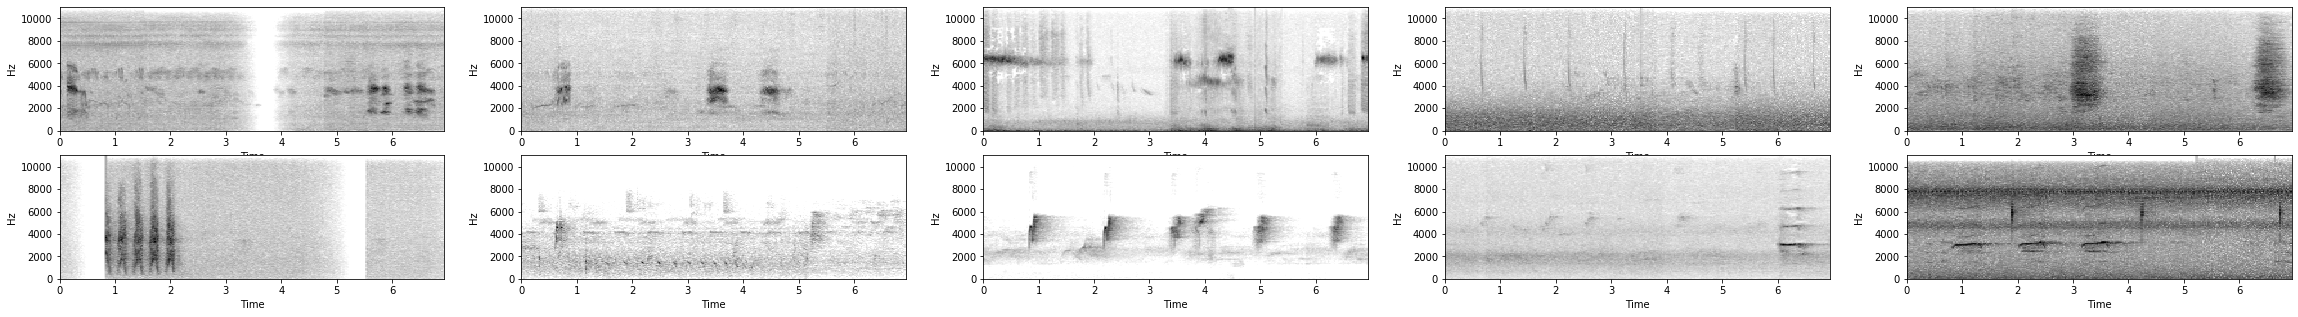

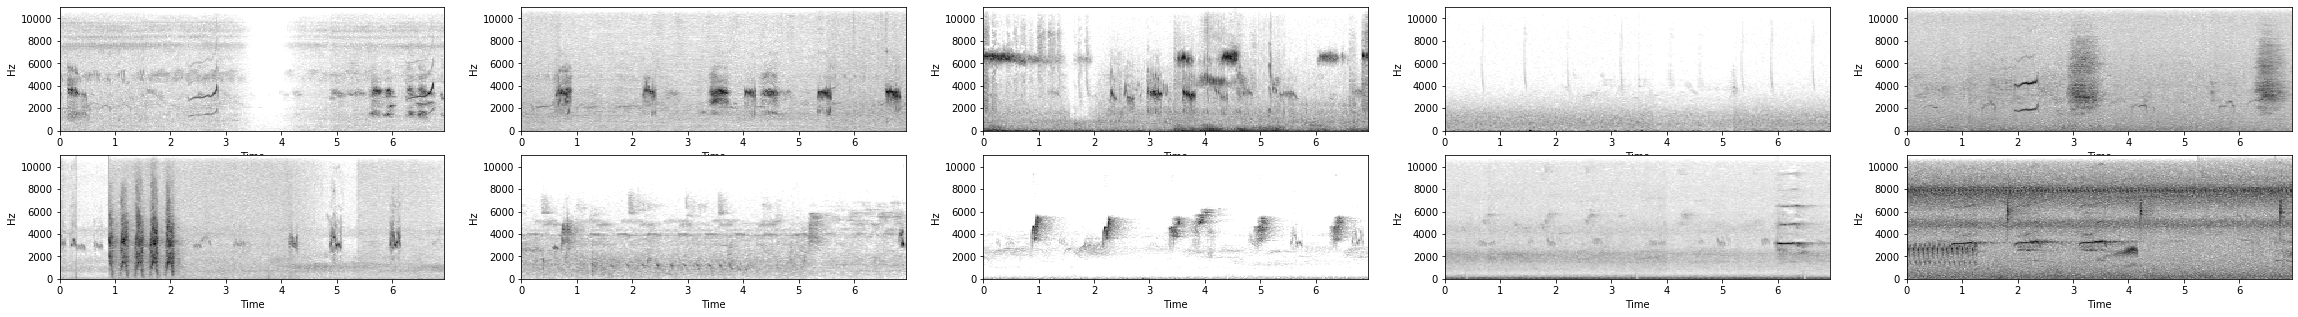

In [12]:
def plot_all(spect_list, size = (12, 20), width = 3):
    import matplotlib.pyplot as plt
    from math import ceil
    
    width = width
    height = ceil(len(spect_list) / width)

    fig, ax = plt.subplots(height, width, figsize = size)
    axes = ax.flatten() # Make accessible by single indices
    
    for idx, spect in enumerate(spect_list): 
        spect_ax = spect.plot_axes(ax = axes[idx])
    
    plt.show()
    
    return fig, ax

for spect_list in spect_lists:
    fig, ax = plot_all(spect_list, width = 5, size = (40, 5))

# Save results

Save images

In [13]:
for idx0, spect_list in enumerate(spect_lists):
    for idx1, spect in enumerate(spect_list):
        save_path = os.path.join(spect_save_path, f'{idx0}_{idx1}.png')
        spect.save_image(path = save_path)

In [14]:
import pandas as pd

Save csv

In [15]:
df = pd.DataFrame(columns=['path', 'manipulations', 'sources', *label_dict.keys()])
for spect_list in spect_lists:
    for spect in spect_list:
        metadata_dict = {
            'path':spect.save_path,
            'manipulations':spect.manipulations,
            'sources':spect.sources,
        }
        labels_present_dict = {}
        for label in label_dict.keys():
            labels_present_dict[label] = int(label in spect.labels)
        metadata_dict.update(labels_present_dict)
        df = df.append(metadata_dict, ignore_index=True)
        
df.to_csv(csv_save_file)